# 1-Layer QG Jet Stability in Firdrake #

Weak Form:

\begin{align*}
c \int \left[ \partial_y \phi \partial_y \hat \psi + (k^2  + F) \phi \hat \psi \right]  \, dy
&= \int \left[ \partial_y (U \phi) \partial_y \hat \psi +  (k^2 U - Q_y) \phi \hat \psi \right] \, dy.
\end{align*}


In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

In [2]:
# Define an Interval Mesh

Ly   = 10.0
Uj   = 0.5
n0   = 200
mesh = IntervalMesh(n0, Ly)
x = SpatialCoordinate(mesh)

# Define parameters

beta = Constant('0.0')
F    = Constant('0.0')

# Profile

profile = 'bickley'
#profile = 'gaussian'
#profile = 'bump'

In [3]:
# Order of the Method

p = 0 # Define CG function space

V  = FunctionSpace(mesh,'CG',p+2)

# Impose zero Dirichlet BCs

bc = DirichletBC(V, 0.0, "on_boundary")

# Define modes 

emodes_real, emodes_imag = Function(V), Function(V)

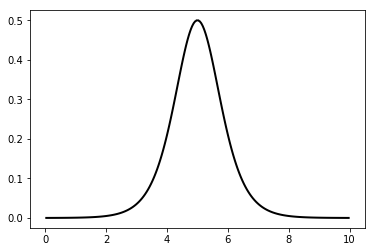

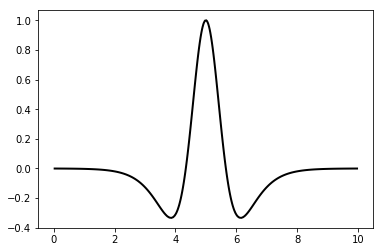

In [4]:
# Define test and trial functions

phi, psi = TestFunction(V), TrialFunction(V)

# Background State
if profile == 'bickley':

    Ub  = Function(V).interpolate(Uj/pow(cosh(x[0]-Ly/2),2))
    dQb = Function(V).interpolate(4.0*Uj*(0.5 - pow(sinh(x[0]-Ly/2),2))/pow(cosh(x[0]-Ly/2),4))
    
elif profile == 'gaussian':
    
    Ub = Function(V).interpolate(Uj*exp(-(x[0]-Ly/2)**2))
    dQb = Function(V).interpolate(-2.*Uj*exp(-(x[0]-Ly/2)**2)*(2.*(x[0]-Ly/2)**2 - 1.))
    #dQb = Function(V).interpolate(-Uj*exp(-(x[0]-Ly/2)**2)*(4.*(x[0]-Ly/2)**2 - 4. - 1./(x[0]-Ly/2)**2))
    
elif profile == 'bump':
    
    Ub = Function(V).interpolate(conditional(lt(abs(x[0]-Ly/2.), 1.0), exp(-1./(1. -(x[0]-Ly/2)**2)), 0.0))
    dQb = Function(V).interpolate(conditional(lt(abs(x[0]-Ly/2.), 1.0), -2.*exp(-1./(1. -(x[0]-Ly/2)**2))*(3.*(x[0]-Ly/2.)**4 - 1)/((x[0]-Ly/2.)**2-1)**4, 0.0))

else:
    
    print("profile must be bickley, gaussian or bump")
    sys.exit()
    
plot(Ub)
plt.show()
plot(dQb)
plt.show()

Weak Form:

\begin{align*}
c \int \left[ \partial_y \phi \partial_y \hat \psi + (k^2  + F) \phi \hat \psi \right]  \, dy
&= \int \left[ \partial_y (U \phi) \partial_y \hat \psi +  (k^2 U - Q_y) \phi \hat \psi \right] \, dy.
\end{align*}

In [5]:
num_eigenvalues = 4

# Wavenumber
dk   = 2e-3
kk   = np.arange(dk, 2.5, dk)
kL   = len(kk)
egs_re  = np.zeros((len(kk),num_eigenvalues))
egs_im  = np.zeros((len(kk),num_eigenvalues))

cnt = 0
for k in kk:

    k2   = Constant(k**2)

    # Define Weak form

    a = ((Ub*phi).dx(0)*psi.dx(0))*dx + ((k2*Ub - dQb - beta)*phi*psi)*dx
    m = (phi.dx(0)*psi.dx(0) + (k2+F)*phi*psi)*dx

    petsc_a = assemble(a).M.handle
    petsc_m = assemble(m, bcs=bc).M.handle

    # Define Petsc options

    opts = PETSc.Options()
    opts.setValue("eps_gen_non_hermitian", None)
    opts.setValue("st_pc_factor_shift_type", "NONZERO")
    #opts.setValue("eps_type", "lapack")
    opts.setValue("eps_type", "krylovschur")
    opts.setValue("eps_largest_imaginary", None)
    opts.setValue("eps_tol", 1e-10)

    # Define Solver options

    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    # Additionally we can find the number of converged eigenvalues. ::

    nconv = es.getConverged()
    imax = min(nconv, num_eigenvalues)
    for i in range(imax):
        vr, vi = petsc_a.getVecs()

        lam = es.getEigenpair(i, vr, vi)
        
        egs_re[cnt,i] = k*lam.real
        egs_im[cnt,i] = k*lam.imag
    
    # Find eigenfunctions
    #emodes_real.vector()[:], emodes_imag.vector()[:] = vr, vi
    #print "Leading eigenvalue is:", lam, " for cnt = ", cnt, " with nconv = ", nconv
    
    cnt += 1
    
print(np.max(abs(egs_im)))

0.080306112605


bickley
0.080306112605 0.0223355995801


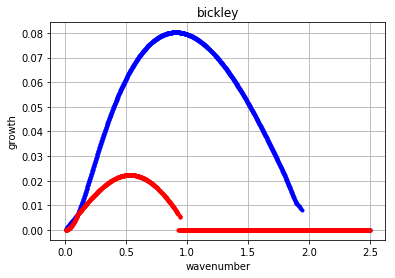

In [7]:
plt.plot(kk,egs_im[:,0],'.b',linewidth=2,label='symmetric')
plt.plot(kk,egs_im[:,2],'.r',linewidth=2,label='antisymmetric')
plt.grid('on')
plt.xlabel('wavenumber')
plt.ylabel('growth')
#plt.title('Growth Rates of Jet: 1LQG')
plt.title(profile)
#plt.xlim([4.7,5.0])
plt.savefig("figure_{0}.png".format(profile))
print(profile)
print(np.max(egs_im[:,0]), np.max(egs_im[:,2]))

## To Do List ##

1. Include Froude number
2. Look at stratified problem
3. Modify Vortex code, 1-layer
4. Stratified Vortex problem